# Lid-Driven Cavity Problem: Physics-Informed Neural Networks (PINNs)

## 1. Problem Statement

The **lid-driven cavity** is a classic benchmark problem in fluid mechanics, involving a square cavity filled with an incompressible viscous fluid. The fluid is set in motion by the uniform movement of the top boundary (the "lid"), while the other three boundaries remain stationary.

- **Domain:**  
  \( (x, y) \in [0, 1] \times [0, 1] \)

- **Governing Equations:**  
  The flow is governed by the steady incompressible Navier–Stokes equations:

  **Continuity:**
  
  $$
  \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
  $$

  **Momentum equations:**

  $$
  u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = -\frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
  $$

  $$
  u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = -\frac{\partial p}{\partial y} + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)
  $$

  where \( u, v \) are the velocity components in \( x \) and \( y \) directions, \( p \) is the pressure, and \( \nu \) is the kinematic viscosity.

- **Boundary Conditions:**
  - **Top lid (\(y=1\)):** \( u=1,\, v=0 \) (lid moves rightward)
  - **Other walls (\(y=0,\, x=0,\, x=1\)):** \( u=0,\, v=0 \) (no-slip, stationary)

- **Reynolds number (\( Re \)):**  
  The Reynolds number, \( Re = \frac{U L}{\nu} \), where \( U \) is the lid velocity and \( L \) is the cavity width, characterizes the flow regime.

---

## 2. Analytical Solution

There is **no exact analytical solution** for the 2D lid-driven cavity flow at moderate or high Reynolds numbers, due to the nonlinear coupling of velocity and pressure fields and the presence of recirculating vortices.

For low Reynolds numbers (\( Re \ll 1 \)), the flow reduces to a linear Stokes flow, which can be approximated analytically, but for most practical cases, solutions are obtained numerically (finite difference, finite volume, spectral methods) or using data-driven approaches such as PINNs.

**Reference numerical solutions** (benchmark data) are available from:

- Ghia, U., Ghia, K. N., & Shin, C. T. (1982). High-Re solutions for incompressible flow using the Navier-Stokes equations and a multigrid method. *Journal of Computational Physics*, 48(3), 387–411. [doi:10.1016/0021-9991(82)90058-4](https://doi.org/10.1016/0021-9991(82)90058-4)
- Schaefer, M., & Turek, S. (1996). The benchmark problem ‘Flow around a cylinder’: a computational and experimental investigation. In *Flow simulation with high-performance computers II* (pp. 547-566). Springer.

---

## 3. References

- [Physics-Informed Neural Networks for the Lid-Driven Cavity Problem – Medium Blog](https://medium.com/@oladayo_7133/solving-the-lid-driven-cavity-problem-using-physics-informed-neural-networks-pinns-2dd14005751a)
- [Ghia et al., 1982 - Benchmark Numerical Results](https://doi.org/10.1016/0021-9991(82)90058-4)
- [PINNs-TF2.x GitHub repository](https://github.com/Vaezi92/PINNs-TF2.x)
- [PINN Lid-Driven Cavity PyTorch Example](https://github.com/okada39/pinn_cavity)

---


In [23]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch.autograd import grad
from scipy.stats import qmc

In [24]:
import torch
import torch.nn as nn

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 3)
        )
    def forward(self, x):
        return self.model(x)

# Test it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PINN().to(device)
xy = torch.rand(4, 2).to(device)
output = model(xy)
print(output.shape)  # Should print: torch.Size([4, 3])
print(output)


torch.Size([4, 3])
tensor([[ 0.1063,  0.0313, -0.2135],
        [ 0.1283, -0.0484, -0.2230],
        [ 0.1109,  0.0536, -0.2002],
        [ 0.1086, -0.0343, -0.2373]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [25]:
## Trainin Data 
def sample_interior_points(N):   # Collocation of the interior points 
    xy= np.random.rand(N,2)
    return torch.tensor(xy, dtype=torch.float32, device=device)

N_f = 10000
xy_f = sample_interior_points(N_f)

def sample_boundary_points(N_per_side):    # Collocation of the boundary points 
    x = np.linspace(0, 1, N_per_side)
    y = np.linspace(0, 1, N_per_side)
    # Bottom
    bottom = np.stack([x, np.zeros_like(x)], axis = 1)
    # Top
    top = np.stack([x, np.ones_like(x)], axis=1)
    # Left wall x = 0 
    left = np.stack([np.zeros_like(y), y], axis=1)
    # Right Wall x = 1
    right = np.stack([np.ones_like(y), y], axis=1)
    #Stacking all the boundaries together 
    boundary = np.vstack([bottom, top , left , right])
    return torch.tensor(boundary, dtype=torch.float32, device= device)

N_b = 200
xy_b = sample_boundary_points(N_b)

# ---- 3. Assign boundary condition values (u, v) at each boundary point ----
def boundary_conditions(xy_b):
    bc = []
    for pt in xy_b.cpu().numpy():
        x, y = pt
        if np.isclose(y, 1.0):     # Top boundary (lid)
            bc.append([1.0, 0.0])  # u=1, v=0
        else:                      # Other boundaries
            bc.append([0.0, 0.0])  # u=0, v=0
    return torch.tensor(bc, dtype=torch.float32, device=device)

bc_vals = boundary_conditions(xy_b)  # [N_b*4, 2]


# ---- Quick check ----
print("Collocation points (interior):", xy_f.shape)
print("Boundary points:", xy_b.shape)
print("Boundary condition values (u,v):", bc_vals.shape)
print("First 5 boundary points and BCs:")
for i in range(5):
    print(xy_b[i].cpu().numpy(), "->", bc_vals[i].cpu().numpy())

Collocation points (interior): torch.Size([10000, 2])
Boundary points: torch.Size([800, 2])
Boundary condition values (u,v): torch.Size([800, 2])
First 5 boundary points and BCs:
[0. 0.] -> [0. 0.]
[0.00502513 0.        ] -> [0. 0.]
[0.01005025 0.        ] -> [0. 0.]
[0.01507538 0.        ] -> [0. 0.]
[0.0201005 0.       ] -> [0. 0.]


In [26]:
def pde_residuals(model, xy, nu):
    # xy: [N,2], requires_grad=True for autodiff
    xy = xy.clone().detach().requires_grad_(True)
    out = model(xy)
    u = out[:, 0:1]
    v = out[:, 1:2]
    p = out[:, 2:3]

    # First derivatives
    u_x = grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0:1]
    u_y = grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1:2]
    v_x = grad(v, xy, grad_outputs=torch.ones_like(v), create_graph=True)[0][:, 0:1]
    v_y = grad(v, xy, grad_outputs=torch.ones_like(v), create_graph=True)[0][:, 1:2]
    p_x = grad(p, xy, grad_outputs=torch.ones_like(p), create_graph=True)[0][:, 0:1]
    p_y = grad(p, xy, grad_outputs=torch.ones_like(p), create_graph=True)[0][:, 1:2]

    # Second derivatives
    u_xx = grad(u_x, xy, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    u_yy = grad(u_y, xy, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1:2]
    v_xx = grad(v_x, xy, grad_outputs=torch.ones_like(v_x), create_graph=True)[0][:, 0:1]
    v_yy = grad(v_y, xy, grad_outputs=torch.ones_like(v_y), create_graph=True)[0][:, 1:2]

    # Residuals
    res_continuity = u_x + v_y
    res_momentum_x = u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
    res_momentum_y = u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)
    return res_continuity, res_momentum_x, res_momentum_y

# Example: For Re = 100
Re = 100
nu = 1.0 / Re


In [27]:
def pinn_loss(model, xy_f, xy_b, bc_vals, nu):
    # Physics loss
    res_c, res_mx, res_my = pde_residuals(model, xy_f, nu)
    loss_pde = (
        torch.mean(res_c**2) +
        torch.mean(res_mx**2) +
        torch.mean(res_my**2)
    )

    # Boundary loss
    pred_b = model(xy_b)
    u_b = pred_b[:, 0:1]
    v_b = pred_b[:, 1:2]
    loss_bc = torch.mean((u_b - bc_vals[:, 0:1])**2) + torch.mean((v_b - bc_vals[:, 1:2])**2)

    # Total loss
    return loss_pde + loss_bc



In [28]:
import torch.optim as optim

# Set up optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 2000  # You can increase this for better accuracy

for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    loss = pinn_loss(model, xy_f, xy_b, bc_vals, nu)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0 or epoch == 1:
        print(f"Epoch {epoch:5d}, Loss: {loss.item():.6f}")

# Plotting
plt.figure()
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()


Epoch     1, Loss: 0.212495
Epoch   100, Loss: 0.085367
Epoch   200, Loss: 0.044479
Epoch   300, Loss: 0.029019
Epoch   400, Loss: 0.024942
Epoch   500, Loss: 0.020217
Epoch   600, Loss: 0.018061
Epoch   700, Loss: 0.017532
Epoch   800, Loss: 0.018283
Epoch   900, Loss: 0.016952
Epoch  1000, Loss: 0.016758
Epoch  1100, Loss: 0.016758
Epoch  1200, Loss: 0.016420
Epoch  1300, Loss: 0.016192
Epoch  1400, Loss: 0.016025
Epoch  1500, Loss: 0.016220
Epoch  1600, Loss: 0.015774
Epoch  1700, Loss: 0.015945
Epoch  1800, Loss: 0.016723
Epoch  1900, Loss: 0.015469
Epoch  2000, Loss: 0.015437


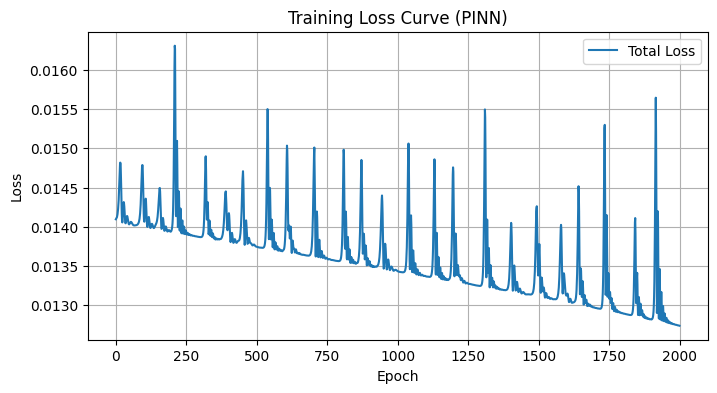

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(loss_history, label="Total Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve (PINN)')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
N_plot = 100  # You can make this 100 for higher resolution
x = np.linspace(0, 1, N_plot)
y = np.linspace(0, 1, N_plot)
X, Y = np.meshgrid(x, y)
xy_grid = np.stack([X.flatten(), Y.flatten()], axis=1)
xy_grid_torch = torch.tensor(xy_grid, dtype=torch.float32, device=device)


In [39]:
model.eval()
with torch.no_grad():
    pred = model(xy_grid_torch)
    u_pred = pred[:,0].cpu().numpy().reshape(N_plot, N_plot)
    v_pred = pred[:,1].cpu().numpy().reshape(N_plot, N_plot)
    p_pred = pred[:,2].cpu().numpy().reshape(N_plot, N_plot)


<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Pradyumn\AppData\Local\Temp\ipykernel_6780\2680345278.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.colorbar(cont, label='Velocity Magnitude $|\mathbf{u}|$')


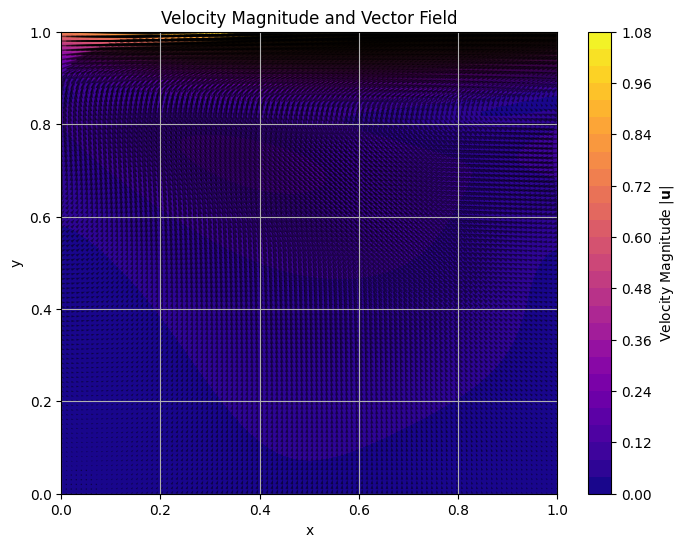

In [40]:
# Calculate velocity magnitude
vel_mag = np.sqrt(u_pred**2 + v_pred**2)

plt.figure(figsize=(8, 6))
cont = plt.contourf(X, Y, vel_mag, levels=30, cmap='plasma')
plt.colorbar(cont, label='Velocity Magnitude $|\mathbf{u}|$')

# Optionally overlay velocity vectors
plt.quiver(X, Y, u_pred, v_pred, scale=4, width=0.003, color='k', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Velocity Magnitude and Vector Field')
plt.grid(True)
plt.show()


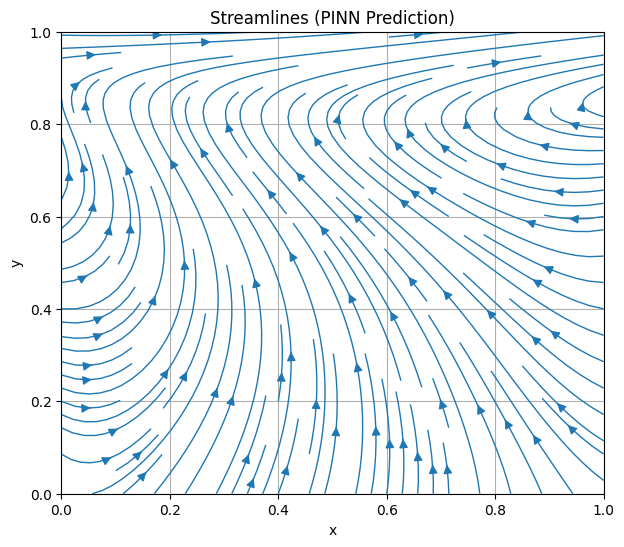

In [41]:
plt.figure(figsize=(7,6))
plt.streamplot(X, Y, u_pred, v_pred, density=1.2, linewidth=1, arrowsize=1.3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Streamlines (PINN Prediction)')
plt.grid(True)
plt.show()


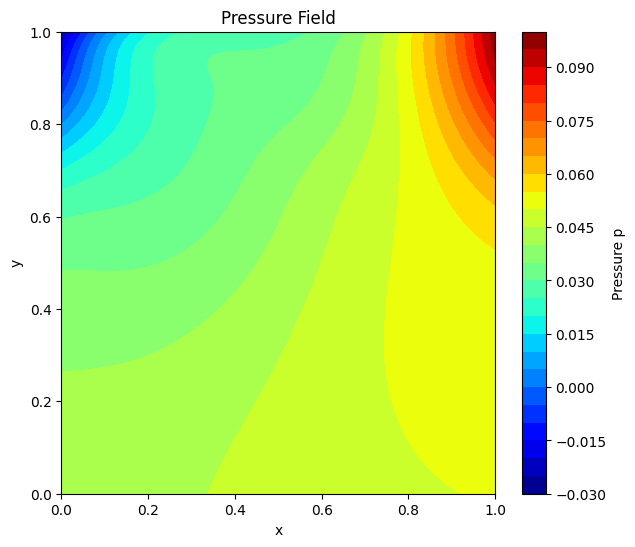

In [42]:
plt.figure(figsize=(7,6))
cont = plt.contourf(X, Y, p_pred, levels=30, cmap='jet')
plt.colorbar(cont, label='Pressure p')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Pressure Field')
plt.show()


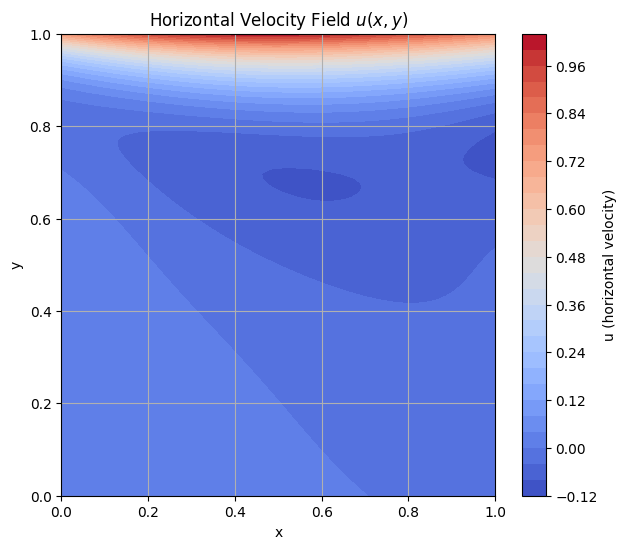

In [43]:
plt.figure(figsize=(7,6))
cont = plt.contourf(X, Y, u_pred, levels=30, cmap='coolwarm')
plt.colorbar(cont, label='u (horizontal velocity)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Horizontal Velocity Field $u(x, y)$')
plt.grid(True)
plt.show()


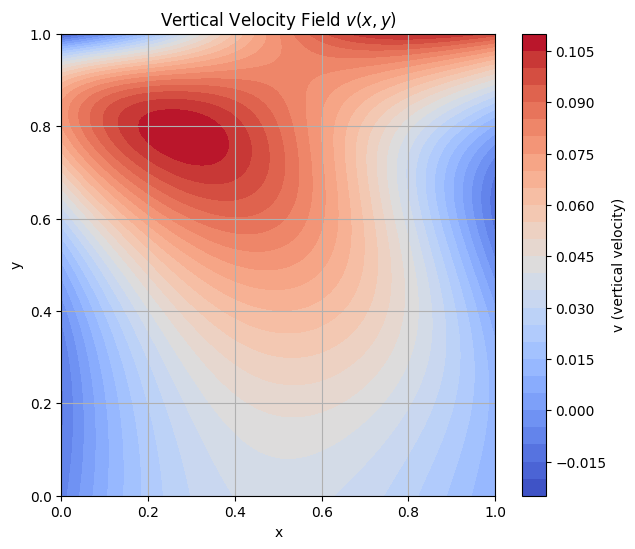

In [44]:
plt.figure(figsize=(7,6))
cont = plt.contourf(X, Y, v_pred, levels=30, cmap='coolwarm')
plt.colorbar(cont, label='v (vertical velocity)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vertical Velocity Field $v(x, y)$')
plt.grid(True)
plt.show()
